In [1]:
import sys
sys.path.append('..')
from osp import *
df_meta = get_corpus_metadata(periodize_by=20).query('year>=1920 and year<2020')

In [2]:
o=[]
for text_id, slice_id, freqs in iter_slice_word_freqs():
    ttok = sum(freqs.values())
    ttyp = len(freqs)
    ttr = ttyp/ttok if ttok>0 else 0
    o.append({'text_id':text_id, 'slice_id':slice_id, 'ttok':ttok, 'ttyp':ttyp, 'ttr':ttr*1000})
df_ttr_slices = pd.DataFrame(o)
df_ttr_slices#.sort_values('ttr', ascending=False).head(10)

100%|██████████| 57620/57620 [00:32<00:00, 1757.72it/s]


,text_id,slice_id,ttok,ttyp,ttr
0,phil/10.2307/40231690,1,1000,377,377.0
1,phil/10.2307/40231690,2,1000,327,327.0
2,phil/10.2307/40231690,3,1000,353,353.0
3,phil/10.2307/40231690,4,1000,361,361.0
4,phil/10.2307/40230399,1,1000,368,368.0
...,...,...,...,...,...
186703,lit/2871890,1,1000,391,391.0
186704,lit/2871890,2,1000,425,425.0
186705,lit/2871890,3,1000,393,393.0
186706,lit/2871890,4,1000,403,403.0


In [3]:
df_ttr = df_ttr_slices.groupby('text_id').mean(numeric_only=True).reset_index()
for x in ['century_discipline', 'decade', 'discipline','journal']:
    df_ttr[x] = df_ttr.text_id.map(df_meta[x])
    df_ttr.groupby(x).ttr.mean().sort_values(ascending=False).sort_index()

In [4]:


def get_avgs_df(df, gby=["period", "source", "prompt_type"], y="rhyme_pred_perc"):
    """
    Calculate summary statistics (mean, standard error, count) for groups in a DataFrame.

    Groups the DataFrame by specified columns and computes descriptive statistics
    for the target variable, including mean, standard error of the mean, and sample count.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data to summarize
    gby : list of str, default=['period', 'source', 'prompt_type']
        Column names to group by for computing statistics
    y : str, default='rhyme_pred_perc'
        Column name containing the values to compute statistics for

    Returns
    -------
    pandas.DataFrame
        DataFrame with summary statistics containing:
        - Grouping columns (from gby parameter)
        - mean: Mean value of y for each group
        - stderr: Standard error of the mean for each group
        - count: Number of observations in each group

    Calls
    -----
    None
    """
    stats_df = (
        df.groupby(gby)[y]
        .agg(
            mean=np.mean,
            stderr=lambda x: x.std() / np.sqrt(len(x)),
            count=len,
        )
        .reset_index()
    )
    return stats_df

In [5]:
import numpy as np

figdf = get_avgs_df(df_ttr,['decade','discipline','journal'], 'ttr')
topj = figdf.groupby('journal').mean(numeric_only=True).sort_values('mean', ascending=False).index
figdf['journal'] = pd.Categorical(figdf['journal'], categories=topj, ordered=True)
figdf = figdf.dropna()
figdf

,decade,discipline,journal,mean,stderr,count
0,1920.0,Literature,Modern Philology,407.141656,2.756014,214
1,1920.0,Literature,PMLA,426.508512,1.657677,405
2,1920.0,Literature,The Modern Language Review,416.079828,2.431801,199
3,1920.0,Literature,The Review of English Studies,409.325455,3.403094,110
4,1920.0,Philosophy,Ethics,403.208283,2.326679,262
...,...,...,...,...,...,...
145,2010.0,Philosophy,Research in Phenomenology,375.440250,2.798641,190
146,2010.0,Philosophy,Synthese,353.769961,0.840172,2033
147,2010.0,Philosophy,The Journal of Philosophy,345.367178,2.332052,283
148,2010.0,Philosophy,The Philosophical Review,339.618855,2.962316,121


In [11]:
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 2.0 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


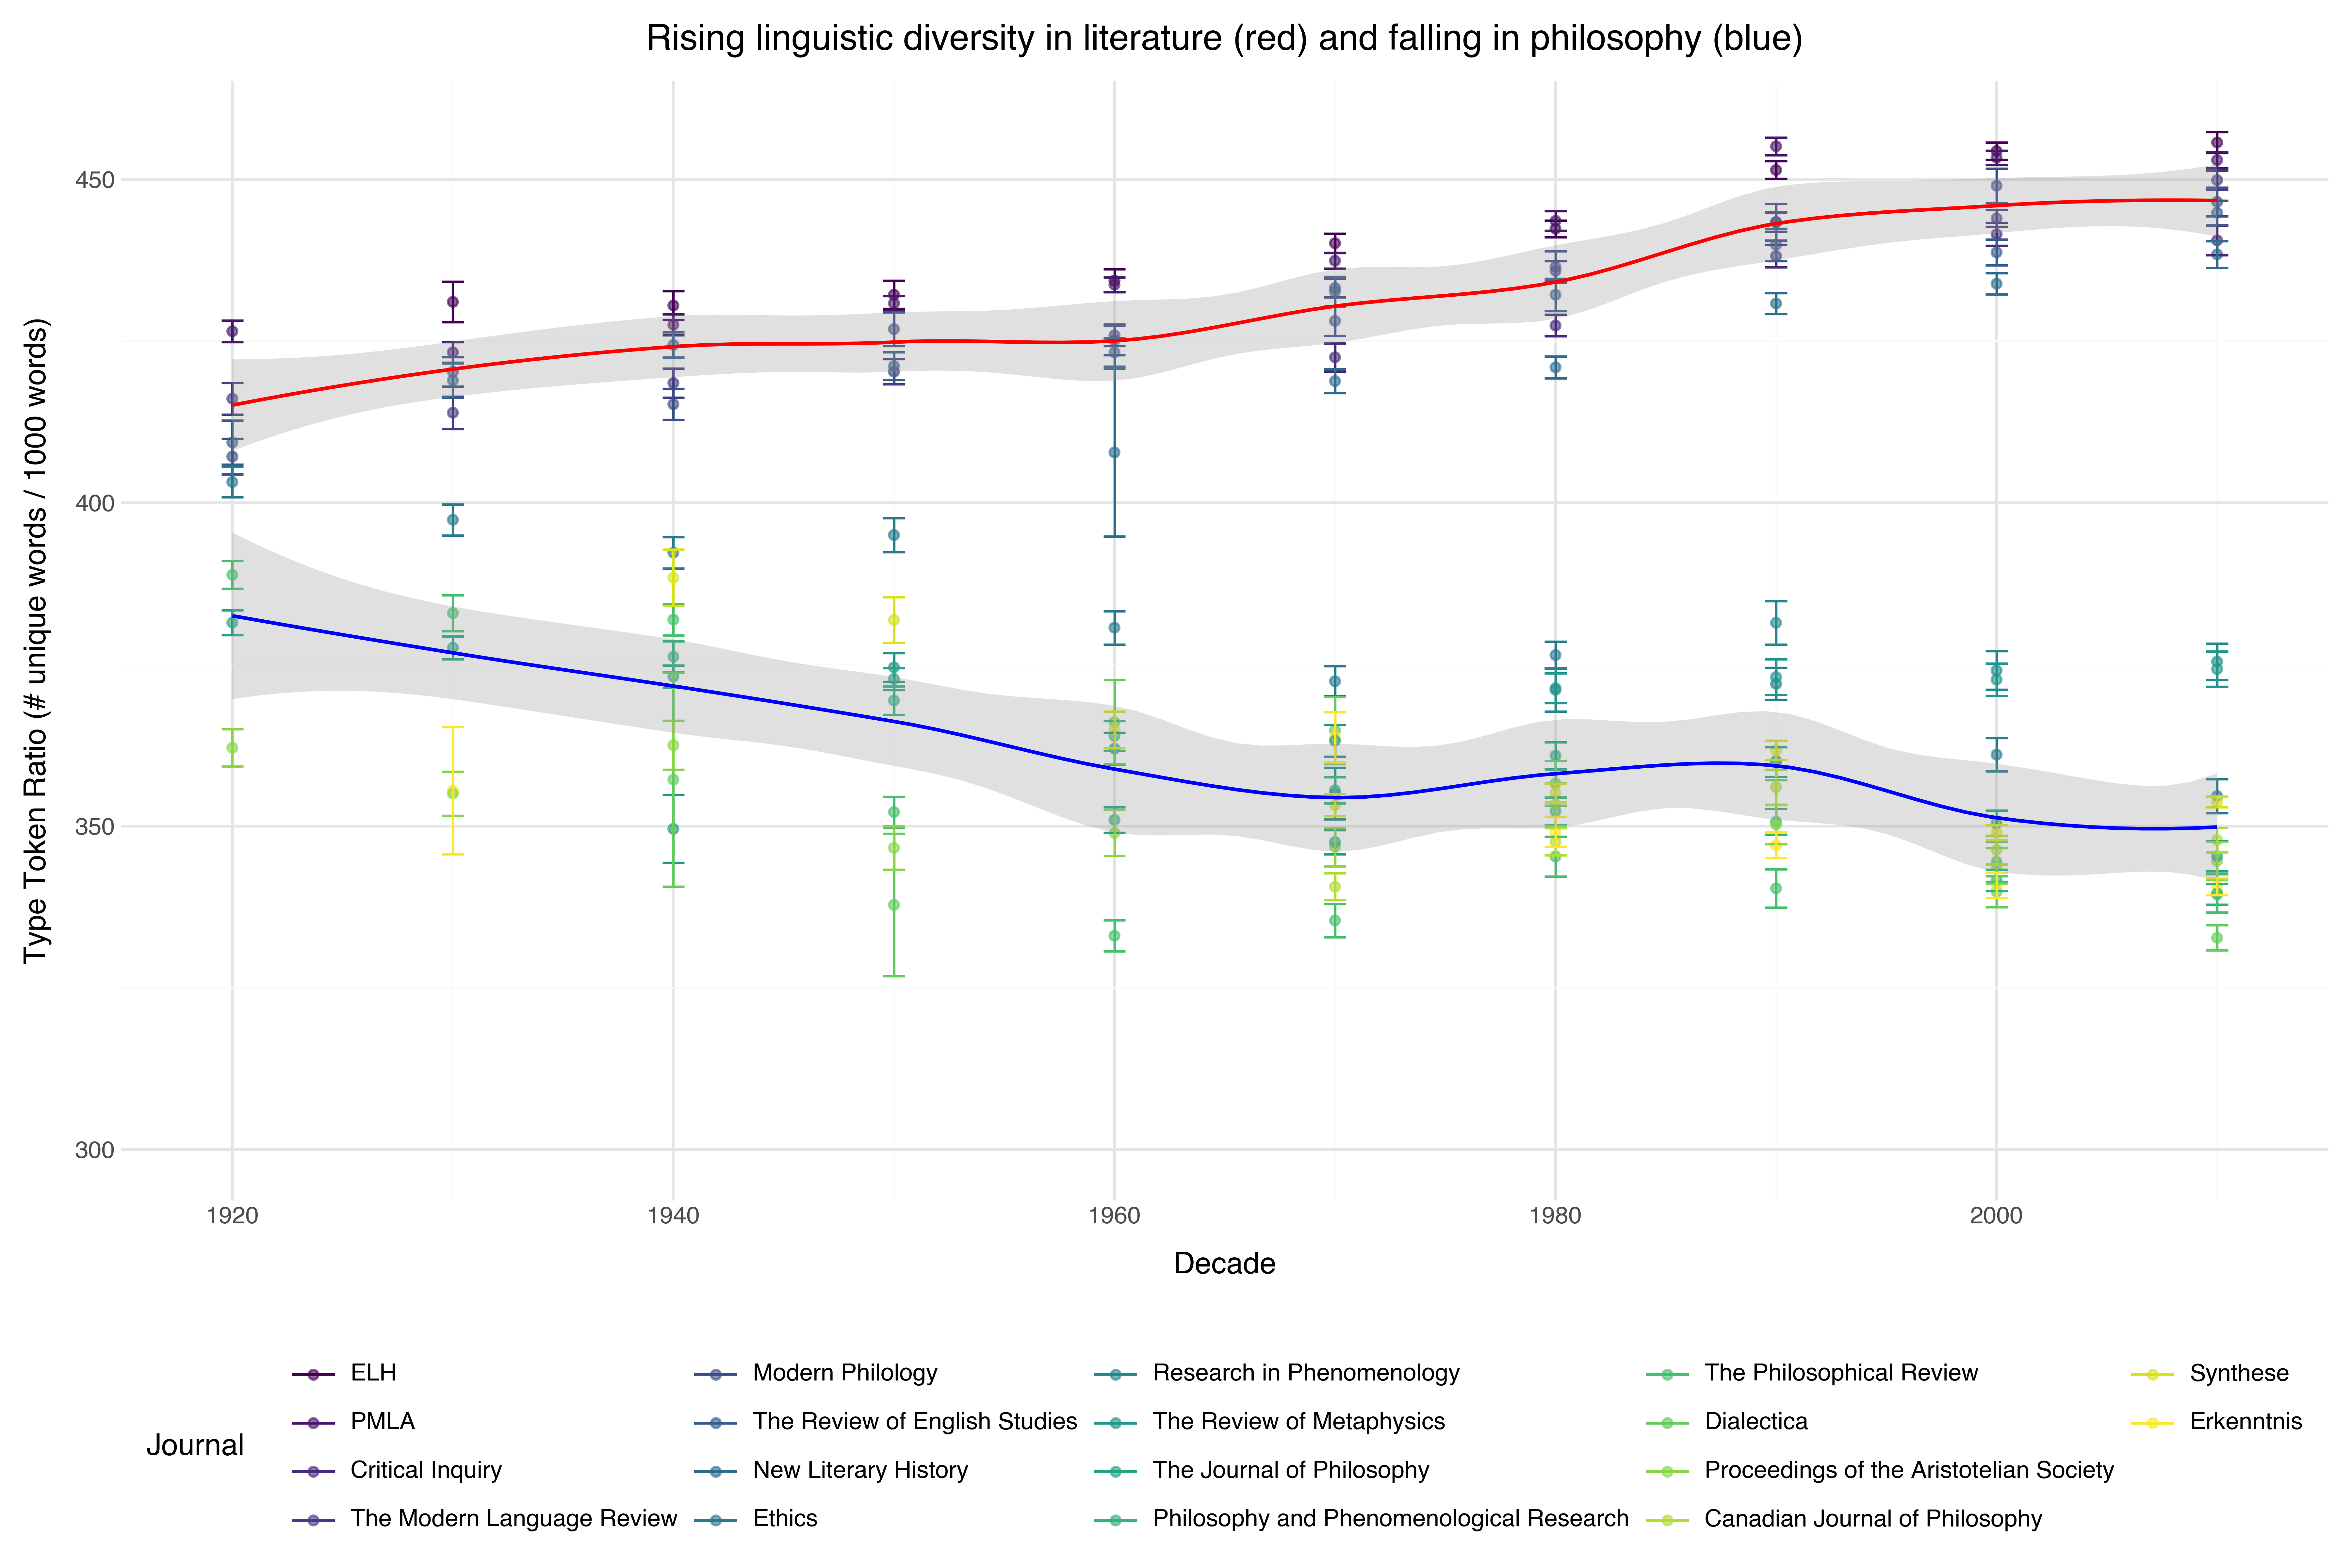

In [46]:
p9.options.figure_size = (12, 8)
fig = p9.ggplot(figdf, p9.aes(x='decade', y='mean'))
fig += p9.geom_point(p9.aes(color='journal'), alpha=0.6)
fig += p9.geom_errorbar(
    p9.aes(ymin='mean - stderr', ymax='mean + stderr', color='journal'),
    width=1,
    # alpha=0.6
)
# fig += p9.geom_line(p9.aes(color='journal'), alpha=0.6)
# fig += p9.facet_wrap('~discipline')
fig += p9.theme_minimal()
fig += p9.scale_y_continuous(limits=(300, None))
# fig += p9.labs(x='Decade', y='TTR')
fig += p9.geom_smooth(p9.aes(group='discipline'), method='loess', span=0.5, alpha=0.3, color='blue', size=.75, data=figdf.query('discipline=="Philosophy"'))
fig += p9.geom_smooth(p9.aes(group='discipline'), method='loess', span=0.5, alpha=0.3, color='red', size=.75, data=figdf.query('discipline=="Literature"'))
fig+=p9.theme(legend_position='bottom')
fig += p9.labs(
    x='Decade',
    y='Type Token Ratio (# unique words / 1000 words)',
    color='Journal',
    title='Rising linguistic diversity in literature (red) and falling in philosophy (blue)'
)
fig

In [38]:
df_ttr.groupby(['discipline','journal']).mean(numeric_only=True).sort_values('ttr', ascending=False)

slice_id         ttok  \
discipline journal                                                           
Literature ELH                                       2.425570  1000.000000   
           PMLA                                      2.001179  1000.000000   
           Critical Inquiry                          2.820940   999.909297   
           The Modern Language Review                1.770388   999.954504   
           The Review of English Studies             1.587981  1000.000000   
           Modern Philology                          1.855309   999.955400   
           New Literary History                      2.566381  1000.000000   
Philosophy Ethics                                    2.899923   999.935873   
           Research in Phenomenology                 2.555556   999.992846   
           The Review of Metaphysics                 2.621425   999.998834   
           The Journal of Philosophy                 2.168599   999.996784   
           The Philosophical Review                  2.777884   999.989090   
           Philosophy and Phenomenological Research  2.601685   999.951541   
           Synthese                                  2.743354   999.991161   
           Proceedings of the Aristotelian Society   2.731104   999.979285   
           Canadian Journal of Philosophy            2.722298   999.973030   
           Dialectica                                2.476500   999.989244   
           Erkenntnis                                2.424186  1000.000000   

                                                           ttyp         ttr  \
discipline journal                                                            
Literature ELH                                       444.168916  444.168916   
           PMLA                                      438.153702  438.153702   
           Critical Inquiry                          434.303967  434.341701   
           The Modern Language Review                433.044281  433.064937   
           The Review of English Studies             430.037163  430.037163   
           Modern Philology                          429.160356  429.180405   
           New Literary History                      428.269025  428.269025   
Philosophy Ethics                                    380.119171  380.141905   
           Research in Phenomenology                 372.547561  372.550429   
           The Review of Metaphysics                 369.458940  369.459420   
           The Journal of Philosophy                 363.722734  363.723803   
           The Philosophical Review                  359.256167  359.260001   
           Philosophy and Phenomenological Research  354.598305  354.614430   
           Synthese                                  354.585713  354.588599   
           Proceedings of the Aristotelian Society   350.562780  350.569977   
           Canadian Journal of Philosophy            347.085546  347.094997   
           Dialectica                                347.068352  347.071703   
           Erkenntnis                                344.249457  344.249457   

                                                          decade  
discipline journal                                                
Literature ELH                                       1978.342498  
           PMLA                                      1965.419764  
           Critical Inquiry                          1990.053540  
           The Modern Language Review                1972.025278  
           The Review of English Studies             1968.792637  
           Modern Philology                          1963.938156  
           New Literary History                      1989.239829  
Philosophy Ethics                                    1965.736196  
           Research in Phenomenology                 1993.470320  
           The Review of Metaphysics                 1974.522396  
           The Journal of Philosophy                 1959.237790  
           The Philosophical Review     

In [48]:
df_ttr.groupby(['discipline','decade']).mean(numeric_only=True).sort_index()


slice_id         ttok        ttyp         ttr
discipline decade                                               
Literature 1920.0  1.689655  1000.000000  417.769340  417.769340
           1930.0  1.651305  1000.000000  421.146541  421.146541
           1940.0  1.736481  1000.000000  424.335541  424.335541
           1950.0  1.854787  1000.000000  427.718074  427.718074
           1960.0  1.925137  1000.000000  430.066314  430.066314
           1970.0  2.228757  1000.000000  431.381624  431.381624
           1980.0  2.330460  1000.000000  433.867430  433.867430
           1990.0  2.358729  1000.000000  443.090360  443.090360
           2000.0  2.238717   999.962906  445.825172  445.841248
           2010.0  2.183507   999.875442  448.152885  448.207638
Philosophy 1920.0  2.281136  1000.000000  386.037361  386.037361
           1930.0  2.258051  1000.000000  376.320186  376.320186
           1940.0  2.397691  1000.000000  377.154934  377.154934
           1950.0  2.167126  1000.000000  369.890666  369.890666
           1960.0  2.175104  1000.000000  358.291220  358.291220
           1970.0  2.344404  1000.000000  353.429425  353.429425
           1980.0  2.597601  1000.000000  357.829545  357.829545
           1990.0  2.806853   999.994965  358.715114  358.716919
           2000.0  2.946444   999.982496  349.098198  349.104535
           2010.0  2.963927   999.918733  349.409791  349.437405

In [49]:
448 / 417

1.0743405275779376

In [50]:
386 / 349

1.1060171919770774